In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import FormatStrFormatter

from game import *
from utils import *
from plots import *
from agents import *
from T4T import *
from nni_pop import *
from nni_pop2 import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def rerun(agents, args, t4tSeedStart=0):
    dfs = []
    for i in range(args['nTest']):
        print(f'test {i}')
        for agent in agents:
            agent.reinitialize(args['player'])
        df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=t4tSeedStart+i).query("ID in @IDs")
        df['t4tSeed'] = [t4tSeedStart+i for _ in range(df.shape[0])]
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    return data

In [3]:
def tTestAndPlot(emp, sim, args, dependent, defect=False):
    player = args['player']
    opponent = args['opponent']
    gameFinal = 14 - args['nFinal']
    player2 = 'trustee' if player=='investor' else 'investor'
    emp = emp.query('game>@gameFinal')
    sim = sim.query('game>@gameFinal')
    if defect:
        emp = emp.query('turn==4')
        sim = sim.query('turn==4')
    yticks = ((0, 0.2, 0.4, 0.6, 0.8, 1.0)) if dependent=='generosity' else ((0, 5, 10, 15, 20, 25, 30))

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((6.38, 2)))
    sns.violinplot(data=emp, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[0], plot='violinplot')
    annot.configure(test="t-test_ind", loc='outside', verbose=1).apply_test().annotate()
    axes[0].set(xlabel=None, title=f'humans vs {opponent} {player2}', yticks=yticks)

    sns.violinplot(data=sim, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=sim, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[1], plot='violinplot')
    annot.configure(test="t-test_ind", loc='outside', verbose=1).apply_test().annotate()
    axes[1].set(xlabel=None, ylabel=None, title=f'agent vs {opponent} {player2}', yticks=yticks)

    sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    plt.tight_layout()
    fig.savefig(f"plots/{args['architecture']}_vs_{opponent}_{player2}_{dependent}.png", dpi=600)

In [6]:
def LTPlot(IDs, sim, args):
    player2 = 'trustee' if args['player']=='investor' else 'investor'
    for ID in IDs:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=((6.38, 2)))
        sns.histplot(data=sim.query("ID==@ID"), x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes, color=palette[0])
        ax2 = axes.twinx()
        sns.lineplot(data=sim.query("ID==@ID"), x='game', y='coins', ax=ax2, color=palette[1])
        axes.set(title=f'{ID} vs {args["opponent"]} trustee',
            xlabel='Game', ylabel='Generosity', xticks=((0,5,10,15)), yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax2.set(ylabel='Score', yticks=((3,6,9,12,15)))
        plt.tight_layout()
        fig.savefig(f"plots/{ID}_vs_{args['opponent']}_{player2}_LT.png", dpi=600)
        plt.close("all")

In [5]:
f = open('data/IBL')
result = json.load(f)
min_loss = 1000
params = {}
for trial in result:
    loss = float(trial['value'])
    if loss <= min_loss:
        min_loss = loss
        params = trial['parameter']
print(params, min_loss)

{'popSeed': 36, 'thrSVO': 0.17, 'tau': 2.5, 'decay': 0.44, 'sigma': 0.78, 'thrA': -1.25, 'gamma': 0.15} 0.6401326673326674


In [6]:
f = open('data/DQN')
result = json.load(f)
min_loss = 1000
params = {}
for trial in result:
    loss = float(trial['value'])
    if loss <= min_loss:
        min_loss = loss
        params = trial['parameter']
print(params, min_loss)

{'popSeed': 20, 'thrSVO': 0.31, 'tau': 3.7, 'gamma': 0.53, 'alpha': 0.498} 0.47790750915750924


# DQN vs Greedy Trustee

In [154]:
f = open('fixed_space_pop.json')
params = json.load(f)
# params2 = {
#     "popSeed": 78,
#     "tau": 12.9,
#     "alpha": 0.029,
#     "gamma": 0.79
# }
params2 = {
    "popSeed": 22,
    "tau": 19.8,
    "alpha": 0.001,
    "gamma": 0.37
}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [155]:
data = rerun(agents, args)

test 0


88 agents selected
proself 55, prosocial 33
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.568e-02 t=1.915e+00


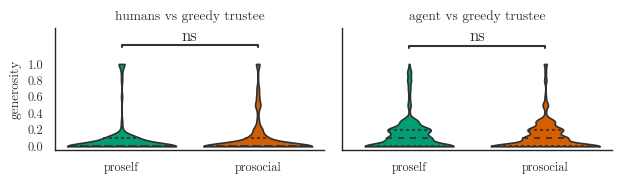

In [156]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [157]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.3095804195804196
0.2111111111111111
0.0


In [145]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# IBL vs Greedy Trustee

In [148]:
f = open('fixed_space_pop.json')
params = json.load(f)
params2 = {
    "popSeed": 9,
    "tau": 1.6,
    "decay": 0.34,
    "sigma": 0.5700000000000001,
    "thrA": -0.79,
    "gamma": 0.15
}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [149]:
data = rerun(agents, args)

test 0


404 agents selected
proself 62, prosocial 342
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.099e-01 t=-1.599e+00


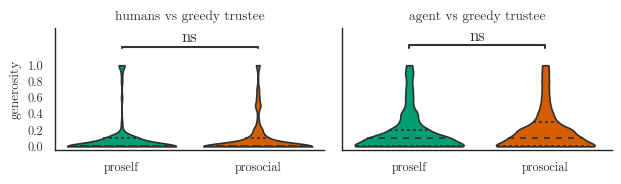

In [150]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [151]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.351985111662531
0.3567251461988304
0.0


In [152]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# DQN vs Generous Trustee

In [44]:
f = open('fixed_space_pop.json')
params = json.load(f)
# params2 = {
#     "popSeed": 690,
#     "tau": 9.4,
#     "alpha": 0.1299,
#     "gamma": 0.2
# }
# params2 = {
#     "popSeed": 89,
#     "tau": 10.200000000000001,
#     "alpha": 0.054,
#     "gamma": 0.34
# }
# params2 = {
#     "popSeed": 76,
#     "thrSVO": 0.33,
#     "tau": 10.4,
#     "alpha": 0.195,
#     "gamma": 0.77
# }
params2 = {
    "popSeed": 89,
    "thrSVO": 0.33,
    "tau": 12.1,
    "alpha": 0.043,
    "gamma": 0.34
}
# params2 = {'popSeed': 20, 'thrSVO': 0.31, 'tau': 3.7, 'gamma': 0.53, 'alpha': 0.498}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [45]:
data = rerun(agents, args)

test 0


105 agents selected
proself 57, prosocial 48
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.209e-23 t=-1.009e+01


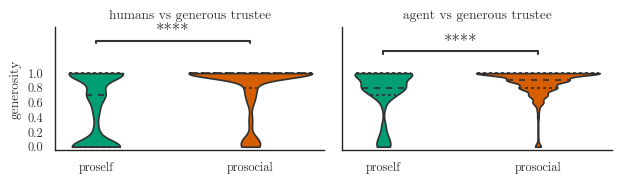

In [28]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [47]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.27268170426065164
0.225
0.11542763157894737


In [49]:
ids = [agent.ID for agent in pop]
LTPlot(ids, sim, args)

In [48]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# IBL vs Generous Trustee

In [51]:
f = open('fixed_space_pop.json')
params = json.load(f)
params2 = {'popSeed': 36, 'thrSVO': 0.17, 'tau': 2.5, 'decay': 0.44, 'sigma': 0.78, 'thrA': -1.25, 'gamma': 0.15}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [52]:
data = rerun(agents, args)

test 0


168 agents selected
proself 25, prosocial 143
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.767e-36 t=-1.274e+01


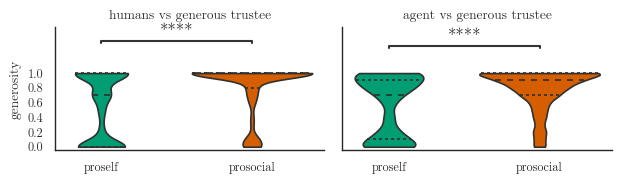

In [53]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [54]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.17885714285714285
0.34965034965034963
0.11162517482517482


In [58]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

In [56]:
ids = [agent.ID for agent in pop]
LTPlot(ids, sim, args)

# Combine simulated and empirical data

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.209e-23 t=-1.009e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.767e-36 t=-1.274e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test indepe

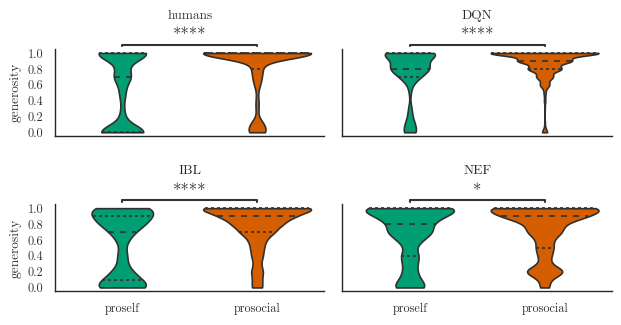

In [10]:
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player=="investor" & opponent=="generous" & game>11')
dqn = pd.read_pickle(f"data/DQN_vs_generous_trustee_violin.pkl").query("game>11")
ibl = pd.read_pickle(f"data/IBL_vs_generous_trustee_violin.pkl").query("game>11")
nef = pd.read_pickle(f"data/NEF_vs_generous_trustee_violin.pkl").query("game>11")
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 3.5)))

sns.violinplot(data=emp, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot1 = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')

sns.violinplot(data=dqn, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot2 = Annotator(pairs=[("proself", "prosocial")], data=dqn, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')

sns.violinplot(data=ibl, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=ibl, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')

sns.violinplot(data=nef, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot4 = Annotator(pairs=[("proself", "prosocial")], data=nef, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][1], plot='violinplot')

annot1.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot2.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot3.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot4.configure(test="t-test_ind", loc='outside').apply_test().annotate()

axes[0][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[0][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[1][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[1][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[0][0].set_title("humans", loc='center', y=1.25)
axes[0][1].set_title("DQN", loc='center', y=1.25)
axes[1][0].set_title("IBL", loc='center', y=1.25)
axes[1][1].set_title("NEF", loc='center', y=1.25)

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.tight_layout()

fig.savefig("plots/sim_generosity2.png", dpi=600)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.209e-23 t=-1.009e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.767e-36 t=-1.274e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test indepe

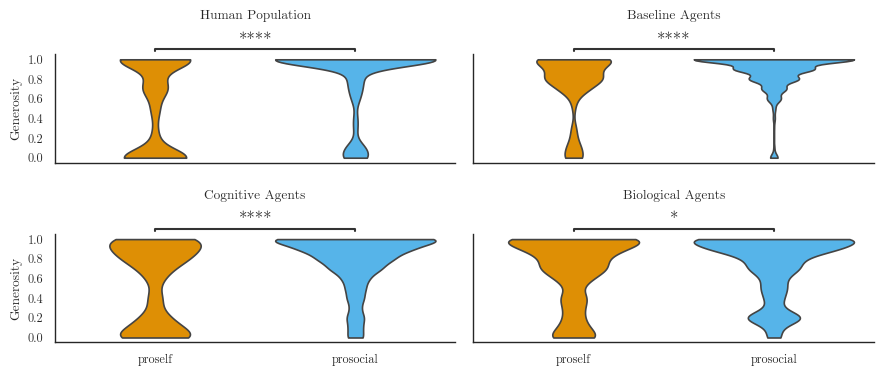

In [7]:
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player=="investor" & opponent=="generous" & game>11')
dqn = pd.read_pickle(f"data/DQN_vs_generous_trustee_violin.pkl").query("game>11")
ibl = pd.read_pickle(f"data/IBL_vs_generous_trustee_violin.pkl").query("game>11")
nef = pd.read_pickle(f"data/NEF_vs_generous_trustee_violin.pkl").query("game>11")
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((9, 4)))

sns.violinplot(data=emp, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][0], palette=p2, saturation=1, inner=None, cut=0, bw=0.2)
annot1 = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')

sns.violinplot(data=dqn, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][1], palette=p2, saturation=1, inner=None, cut=0, bw=0.2)
annot2 = Annotator(pairs=[("proself", "prosocial")], data=dqn, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')

sns.violinplot(data=ibl, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][0], palette=p2, saturation=1, inner=None, cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=ibl, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')

sns.violinplot(data=nef, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][1], palette=p2, saturation=1, inner=None, cut=0, bw=0.2)
annot4 = Annotator(pairs=[("proself", "prosocial")], data=nef, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][1], plot='violinplot')

annot1.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot2.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot3.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot4.configure(test="t-test_ind", loc='outside').apply_test().annotate()

axes[0][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel="Generosity")
axes[0][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[1][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel="Generosity")
axes[1][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[0][0].set_title("Human Population", loc='center', y=1.25)
axes[0][1].set_title("Baseline Agents", loc='center', y=1.25)
axes[1][0].set_title("Cognitive Agents", loc='center', y=1.25)
axes[1][1].set_title("Biological Agents", loc='center', y=1.25)

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.tight_layout()

# fig.savefig("plots/sim_generosity2.png", dpi=600)
fig.savefig("plots/sim_generosity_generous.svg")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.209e-23 t=-1.009e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.767e-36 t=-1.274e+01


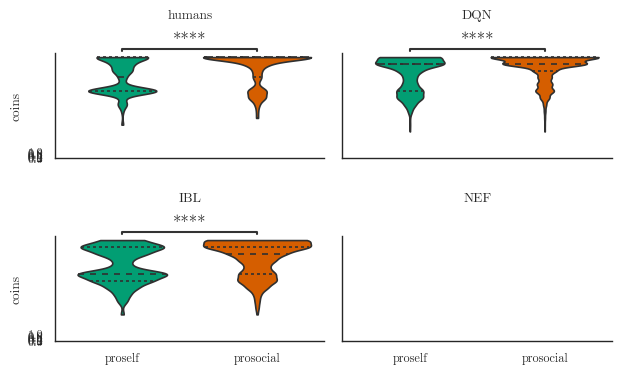

In [74]:
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player=="investor" & opponent=="generous" & game>11')
dqn = pd.read_pickle(f"data/DQN_vs_generous_trustee_violin.pkl").query("game>11")
ibl = pd.read_pickle(f"data/IBL_vs_generous_trustee_violin.pkl").query("game>11")
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 4)))

sns.violinplot(data=emp, x="orientation", y="coins", order=["proself", "prosocial"], ax=axes[0][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot1 = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')

sns.violinplot(data=dqn, x="orientation", y="coins", order=["proself", "prosocial"], ax=axes[0][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot2 = Annotator(pairs=[("proself", "prosocial")], data=dqn, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')

sns.violinplot(data=ibl, x="orientation", y="coins", order=["proself", "prosocial"], ax=axes[1][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=ibl, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')

annot1.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot2.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot3.configure(test="t-test_ind", loc='outside').apply_test().annotate()

axes[0][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[0][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[1][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[1][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[0][0].set_title("humans", loc='center', y=1.25)
axes[0][1].set_title("DQN", loc='center', y=1.25)
axes[1][0].set_title("IBL", loc='center', y=1.25)
axes[1][1].set_title("NEF", loc='center', y=1.25)

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.tight_layout()

fig.savefig("plots/sim_Ttest_coins_generoustrustee.png", dpi=600)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.046e-02 t=-2.562e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.099e-01 t=-1.599e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test indepe

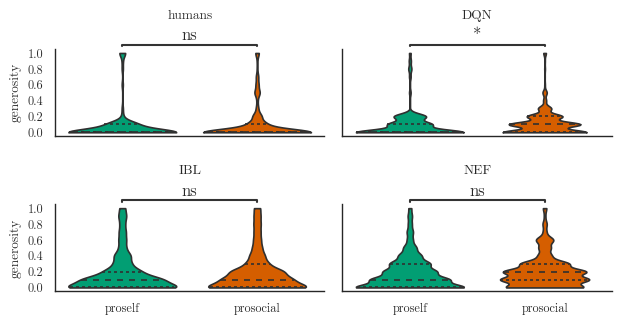

In [9]:
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player=="investor" & opponent=="greedy" & game>11')
dqn = pd.read_pickle(f"data/DQN_vs_greedy_trustee_violin.pkl").query("game>11")
ibl = pd.read_pickle(f"data/IBL_vs_greedy_trustee_violin.pkl").query("game>11")
nef = pd.read_pickle(f"data/NEF_vs_greedy_trustee_violin.pkl").query("game>11")
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 3.5)))

sns.violinplot(data=emp, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot1 = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')

sns.violinplot(data=dqn, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot2 = Annotator(pairs=[("proself", "prosocial")], data=dqn, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')

sns.violinplot(data=ibl, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=ibl, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')

sns.violinplot(data=nef, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot4 = Annotator(pairs=[("proself", "prosocial")], data=nef, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][1], plot='violinplot')

annot1.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot2.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot3.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot4.configure(test="t-test_ind", loc='outside').apply_test().annotate()

axes[0][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[0][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[1][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[1][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[0][0].set_title("humans", loc='center', y=1.25)
axes[0][1].set_title("DQN", loc='center', y=1.25)
axes[1][0].set_title("IBL", loc='center', y=1.25)
axes[1][1].set_title("NEF", loc='center', y=1.25)

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.tight_layout()

fig.savefig("plots/sim_generosity1.png", dpi=600)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.046e-02 t=-2.562e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.099e-01 t=-1.599e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test indepe

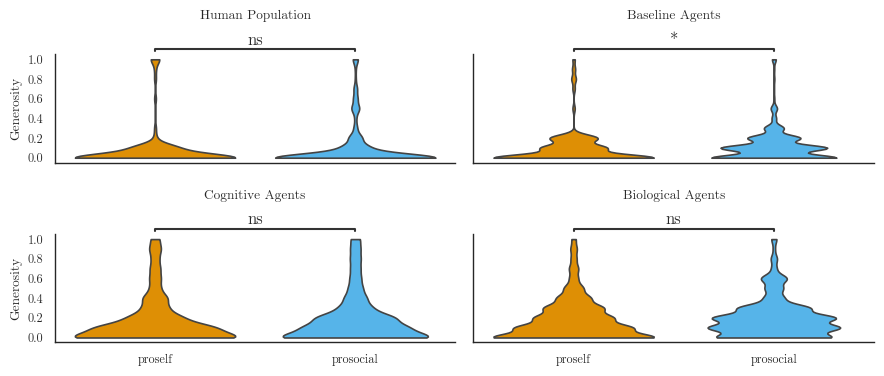

In [8]:
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player=="investor" & opponent=="greedy" & game>11')
dqn = pd.read_pickle(f"data/DQN_vs_greedy_trustee_violin.pkl").query("game>11")
ibl = pd.read_pickle(f"data/IBL_vs_greedy_trustee_violin.pkl").query("game>11")
nef = pd.read_pickle(f"data/NEF_vs_greedy_trustee_violin.pkl").query("game>11")
p2 = ["#de8f05ff", "#56b4e9ff"]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((9, 4)))

sns.violinplot(data=emp, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][0], palette=p2, saturation=1, inner=None, cut=0, bw=0.2)
annot1 = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')

sns.violinplot(data=dqn, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][1], palette=p2, saturation=1, inner=None, cut=0, bw=0.2)
annot2 = Annotator(pairs=[("proself", "prosocial")], data=dqn, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')

sns.violinplot(data=ibl, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][0], palette=p2, saturation=1, inner=None, cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=ibl, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')

sns.violinplot(data=nef, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][1], palette=p2, saturation=1, inner=None, cut=0, bw=0.2)
annot4 = Annotator(pairs=[("proself", "prosocial")], data=nef, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][1], plot='violinplot')

annot1.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot2.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot3.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot4.configure(test="t-test_ind", loc='outside').apply_test().annotate()

axes[0][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel="Generosity")
axes[0][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[1][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel="Generosity")
axes[1][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[0][0].set_title("Human Population", loc='center', y=1.25)
axes[0][1].set_title("Baseline Agents", loc='center', y=1.25)
axes[1][0].set_title("Cognitive Agents", loc='center', y=1.25)
axes[1][1].set_title("Biological Agents", loc='center', y=1.25)

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.tight_layout()

fig.savefig("plots/sim_generosity_greedy.svg")

### plot NEF LTs

In [7]:
sim = pd.read_pickle(f"data/NEF_vs_generous_trustee_violin.pkl")
ids = sim['ID'].unique()
params = {
    "architecture": "NEF",
    "player": "investor",
    "opponent": "generous",
    "nAgents": 100,
    "nTrain": 1,
    "nTest": 1,
    "nGames": 15,
    "explore": "exponential",
    "update": "Q-learning",
    "w_s": 1,
    "w_o": 0.3,
    "w_i": 0.3,
    "nFinal": 3,
    "optimize_target": "final",
    "overlap_test": "ks",
    "popSize": 10,
}
params2 = {
    "popSeed": 0,
    "thrSVO": 0.3,
    "tau": 3,
    "alpha": 1e-7,
    "gamma": 0.3,
    "nStates": 160,
    "radius": 0.5,
}
args = params | params2
LTPlot(ids, sim, args)

# Late Defect

### nni_pop2 score

In [66]:
f = open('fixed2.json')
params = json.load(f)
# params2 = {
#     "popSeed": 498,
#     "tau": 1,
#     "alpha": 0.052,
#     "gamma": 0.31,
#     "w_o": 0.21,
#     "w_i": 0.36
# }
params2 = {
    "popSeed": 813,
    "tau": 2.2,
    "alpha": 0.378,
    "gamma": 0.24,
    "w_o": 0.2,
    "w_i": 0.37
}
args = params | params2
agents = makePopulation2(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("human_data.pkl").query('player==@player & opponent==@opponent')

In [67]:
data = rerun(agents, args)

test 0


In [68]:
pop, selected = agents, data
sim = addLabel2(pop, selected, args)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:7.026e-44 t=-1.433e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:0.000e+00 t=-7.963e+01


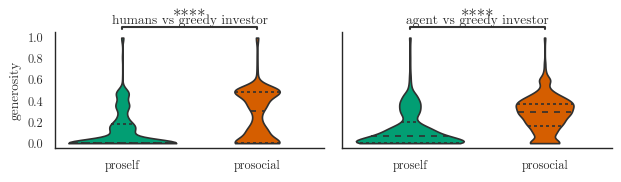

In [69]:
tTestAndPlot(emp, sim, args, 'generosity', defect=False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.761e-13 t=7.431e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:0.000e+00 t=3.811e+01


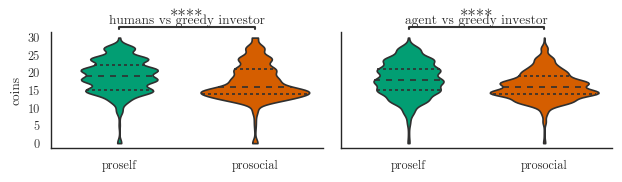

In [70]:
tTestAndPlot(emp, sim, args, 'coins', defect=False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:2.513e-07 t=-5.273e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.165e-278 t=-3.738e+01


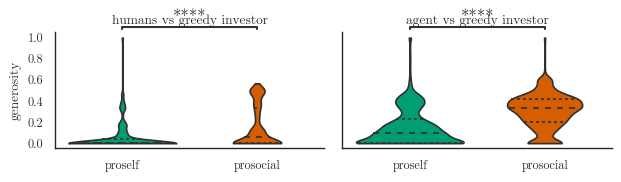

In [71]:
tTestAndPlot(emp, sim, args, 'generosity', defect=True)

In [ ]:
# sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# IBL vs greedy investor

In [37]:
f = open('fixed2.json')
params = json.load(f)
params2 = {
    "popSeed": 648,
    "tau": 1.2000000000000002,
    "alpha": 0.002,
    "gamma": 0.62,
    "decay": 0.61,
    "sigma": 0.49,
    "thrA": -1.8800000000000001,
    "w_o": 0.33,
    "w_i": 0.48
}
args = params | params2
agents = makePopulation2(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("human_data.pkl").query('player==@player & opponent==@opponent')

In [38]:
data = rerun(agents, args)

test 0


In [39]:
pop, selected = agents, data
sim = addLabel2(pop, selected, args)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:7.026e-44 t=-1.433e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:0.000e+00 t=-4.820e+01


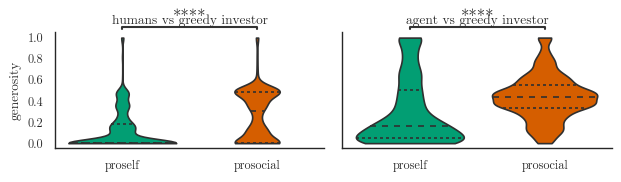

In [40]:
tTestAndPlot(emp, sim, args, 'generosity', defect=False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.761e-13 t=7.431e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.420e-296 t=3.717e+01


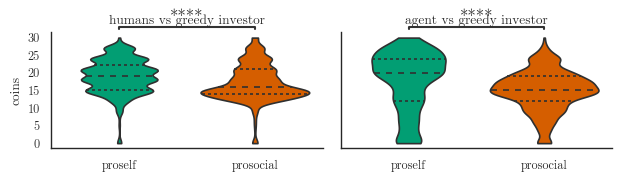

In [41]:
tTestAndPlot(emp, sim, args, 'coins', defect=False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:2.513e-07 t=-5.273e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.078e-256 t=-3.573e+01


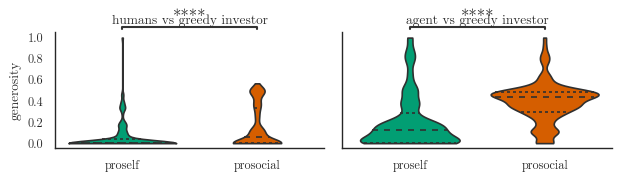

In [42]:
tTestAndPlot(emp, sim, args, 'generosity', defect=True)

In [11]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# combine defect

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:8.938e-05 t=-4.044e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.165e-278 t=-3.738e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:2.037e-01 t=-1.272e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test indep

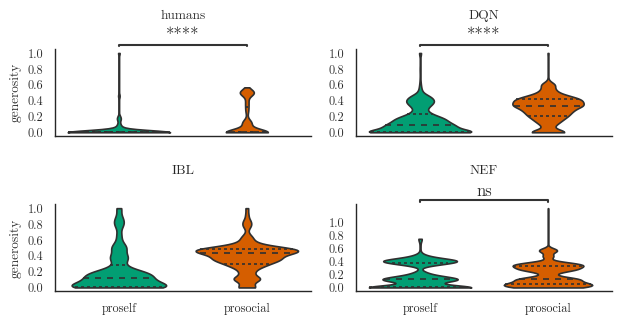

In [15]:
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player=="trustee" & opponent=="greedy" & game>11 & turn==4')
dqn = pd.read_pickle(f"data/DQN_vs_greedy_investor_violin.pkl").query("game>11 & turn==4")
ibl = pd.read_pickle(f"data/IBL_vs_greedy_investor_violin.pkl").query("game>11 & turn==4")
nef = pd.read_pickle(f"data/NEF_vs_greedy_investor_violin.pkl").query("game>11 & turn==4")
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=((6.38, 3.5)))

sns.violinplot(data=emp, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot1 = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][0], plot='violinplot')

sns.violinplot(data=dqn, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[0][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot2 = Annotator(pairs=[("proself", "prosocial")], data=dqn, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[0][1], plot='violinplot')

sns.violinplot(data=ibl, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=ibl, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][0], plot='violinplot')

sns.violinplot(data=nef, x="orientation", y="generosity", order=["proself", "prosocial"], ax=axes[1][1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
annot3 = Annotator(pairs=[("proself", "prosocial")], data=nef, x='orientation', y='generosity', order=["proself", "prosocial"], ax=axes[1][1], plot='violinplot')

annot1.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot2.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot3.configure(test="t-test_ind", loc='outside').apply_test().annotate()
annot4.configure(test="t-test_ind", loc='outside').apply_test().annotate()

axes[0][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[0][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[1][0].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None)
axes[1][1].set(yticks=((0,0.2,0.4,0.6,0.8,1.0)), xlabel=None, ylabel=None)
axes[0][0].set_title("humans", loc='center', y=1.25)
axes[0][1].set_title("DQN", loc='center', y=1.25)
axes[1][0].set_title("IBL", loc='center', y=1.25)
axes[1][1].set_title("NEF", loc='center', y=1.25)

sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.tight_layout()

fig.savefig("plots/sim_defect.png", dpi=600)